## Primer on Keras

In this notebook, we will learn how to implement a neural network using Keras API with TensorFlow backend. Keras provides a user-friendly interface to use TensorFlow and build the models quickly. Both Keras and TensorFlow are robust and powerful python libraries commonly used for deep learning.

There are two ways to build models in Keras, sequential and functional. 
* The sequential API allows us to create layer-by-layer models with multiple inputs and outputs, but is limited in its flexibility. 
* The functional API allows us to create models where we can connect any layer to any other layer, rather than only the layers immediately adjacent to it. It is useful for more advanced architectures where sequential API no longer suffices.

In this primer we will be focusing on the sequential API for ease and clarity.

Let us first import the IMDb reviews data into a pandas dataframe `df`.

In [ ]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings("ignore")


# from google.colab import drive
# drive.mount("/content/gdrive")


In [1]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We will train a neural network to classify the sentiment's reviews into positive and negative.

Let us check the number of rows and columns in the dataset.

In [2]:
df.shape

(50000, 2)

Let us check the number of positive and negative reviews in our dataset.

In [3]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

There are equal number of positive and negative reviews.

Now we want to split the data into training and testing sets. This is for model cross-validation, that is once our network is trained using training data, we want to measure its performance on the unseen validation data.

In [4]:
from sklearn.model_selection import train_test_split
# default is 75% / 25% train-test split
X = df['review'] 
y = df['sentiment'].replace({'positive': 1, 'negative': 0})
text_train, text_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

Let us use the TF-IDF vectorizer along with `clean_text` function above to vectorize the text data.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score


# Vectorization
vectorizer = TfidfVectorizer(stop_words="english",
                             max_features=15000)

X_train_vectorized = vectorizer.fit_transform(text_train)    
X_valid_vectorized = vectorizer.transform(text_valid)

We convert the CSR matrices to numpy arrays so that they can be feed into Keras model.

In [6]:
X_train = X_train_vectorized.toarray()
X_valid = X_valid_vectorized.toarray()

For the purpose of reproducibility, we seed first.

In [7]:
from numpy.random import seed
seed(10)

import tensorflow as tf

### Constructing a simple network

We import the relevant functions from [Keras](https://keras.io/) that we plan to use in our network.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import he_normal
from keras.callbacks import ModelCheckpoint, EarlyStopping


input_dim = X_train.shape[1] # size of input variables

Using TensorFlow backend.


Let us first look at the shapes of the training and validation sets.

In [9]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(37500, 15000) (12500, 15000) (37500,) (12500,)


We begin by initializing a Sequential model using [Keras Sequential API](https://keras.io/getting-started/sequential-model-guide/).

In [10]:
model = Sequential()

Notes:
* We add layers to the model via the [`.add()`](https://keras.io/getting-started/sequential-model-guide/) method. 
* Keras API allows us to define various kinds of layers that are useful for more involved architectures, but for the Multi-layer Perceptrons, we use [`Dense`](https://keras.io/layers/core/) layers, which simply means each node in one layer is connected to every node in the next.
* The very first layer added to the model needs to be given the input shape (`input_shape`) or input dimension (`input_dim`).
* The dropout regularization can be added to a layer by using `model.add(Dropout(0.5))` right after it
* The other properties we will specify for the Dense layers are
    * units: the number of nodes in a particular layer
    * activation: we will use ReLU and sigmoid activation functions for hidden and output layer respectively
    * kernel_initializer: for initializing weights and biases
    
Let us add the first fully-connected (dense) layer with the sigmoid activation using [`.add()`](https://keras.io/getting-started/sequential-model-guide/) method with [`Dense`](https://keras.io/layers/core/) layer. This is the hidden layer with 64 nodes (or units).

In [11]:
model.add(Dense(units=64, input_dim=input_dim, activation="relu", kernel_initializer=he_normal())) # Hidden layer
model.add(Dropout(0.5)) # Adding dropout regularization to the hidden layer with dropout prob=0.5

Now, we add the output layer. 
* No need to specify the input size, Keras will automatically take it to be 64 - same as the output size of the previous layer. 
* We specify the the number of units for this layer to be 1 - to give use the prediction of whether the review is positive or negative.

In [12]:
model.add(Dense(units=1, activation="sigmoid")) # Output layer

Let us check the structure of the network using the [`.summary()`](https://keras.io/models/about-keras-models/) function.

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                960064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 960,129
Trainable params: 960,129
Non-trainable params: 0
_________________________________________________________________


This seems to give us the desired structure. Keep in mind that in practice we want to optimize the number of nodes per hidden layer and number of hidden layers, while in this example the layers were chosen for explanatory purposes.

### Training the model 

Now that we have defined our network architecture, we need to compile it first using [`compile`](https://keras.io/models/model/) before running it. There are a few keywords that we need to pass:
* `optimizer`: We will use the Adam method.
* `loss`: This is nothing but the cost function. We want to build a model for binary classification and hence will use binary cross-entropy loss.
* `metrics`: We will simply use the accuracy.


In [14]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

Finally, we train the model using 8 rounds (epochs) over the entire training set.

In [15]:
model_history = model.fit(X_train, y_train.values, 
                          epochs=8, batch_size=1024, 
                          validation_data=(X_valid, y_valid.values), verbose=1); 

Train on 37500 samples, validate on 12500 samples
Epoch 1/8
37500/37500 [==============================] - 30s 800us/step - loss: 0.6394 - acc: 0.7818 - val_loss: 0.5697 - val_acc: 0.8521
Epoch 2/8
37500/37500 [==============================] - 26s 681us/step - loss: 0.4999 - acc: 0.8656 - val_loss: 0.4475 - val_acc: 0.8674
Epoch 3/8
37500/37500 [==============================] - 24s 636us/step - loss: 0.3898 - acc: 0.8837 - val_loss: 0.3666 - val_acc: 0.8761
Epoch 4/8
37500/37500 [==============================] - 23s 615us/step - loss: 0.3195 - acc: 0.8997 - val_loss: 0.3200 - val_acc: 0.8855
Epoch 5/8
37500/37500 [==============================] - 23s 604us/step - loss: 0.2721 - acc: 0.9123 - val_loss: 0.2928 - val_acc: 0.8888
Epoch 6/8
37500/37500 [==============================] - 23s 619us/step - loss: 0.2414 - acc: 0.9200 - val_loss: 0.2764 - val_acc: 0.8896
Epoch 7/8
37500/37500 [==============================] - 23s 622us/step - loss: 0.2190 - acc: 0.9263 - val_loss: 0.2665 - 

We can plot the loss function values  for training and validation sets over the epochs using `model_history`.

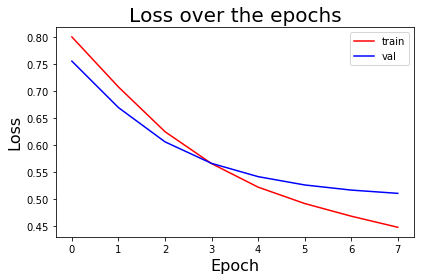

In [16]:
import matplotlib.pyplot as plt
def plot_loss(model_history):
    fig, ax = plt.subplots()
    plt.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
    plt.plot(np.sqrt(model_history.history['val_loss']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=16)
    ax.set_ylabel(r'Loss', fontsize=16)
    plt.legend()
    plt.title("Loss over the epochs", fontsize=20)
    fig.tight_layout()
    plt.show()

    
plot_loss(model_history)

We can also plot the accuracy values for training and validation sets over the epochs using `model_history`.

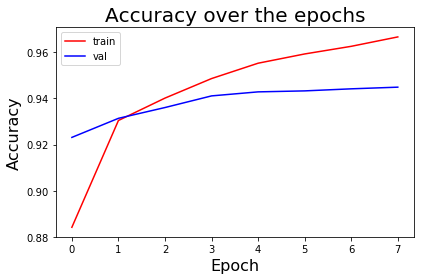

In [17]:
def plot_accuracy(model_history):
    fig, ax = plt.subplots()
    plt.plot(np.sqrt(model_history.history['acc']), 'r', label='train')
    plt.plot(np.sqrt(model_history.history['val_acc']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=16)
    ax.set_ylabel(r'Accuracy', fontsize=16)
    plt.legend()
    plt.title("Accuracy over the epochs", fontsize=20)
    fig.tight_layout()
    plt.show()
plot_accuracy(model_history)

Certain functions from `keras.callbacks` are particularly useful. We will use `keras.callbacks.EarlyStopping` to stop the training process early based on a loss function values for the validation set. Here, we use `mode='min'` as we are trying to minimize the validation loss.

In [18]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

We can also save the weight for the model using `keras.callbacks.ModelCheckpoint` so that we can retrieve them and do not loose our work even if our kernel quit unexpectedly.

In [19]:
filepath = 'IMDb_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

We can also use `keras.callbacks.Tensorboard` to plot the logs obtaining from the training process.

In [ ]:
tensorboard_callback = TensorBoard(log_dir="./logs")

Let us use the `keras.callbacks` for training the network.

In [20]:
callbacks = [checkpoint, earlystopping]
model_history = model.fit(X_train, y_train.values, 
                          epochs=10, batch_size=1024, 
                          validation_data=(X_valid, y_valid.values), verbose=1,
                          callbacks=callbacks)

Train on 37500 samples, validate on 12500 samples
Epoch 1/10
37500/37500 [==============================] - 23s 619us/step - loss: 0.1853 - acc: 0.9385 - val_loss: 0.2576 - val_acc: 0.8918
Epoch 2/10
37500/37500 [==============================] - 24s 634us/step - loss: 0.1727 - acc: 0.9439 - val_loss: 0.2558 - val_acc: 0.8934
Epoch 3/10
37500/37500 [==============================] - 25s 665us/step - loss: 0.1623 - acc: 0.9462 - val_loss: 0.2560 - val_acc: 0.8918
Epoch 00003: early stopping


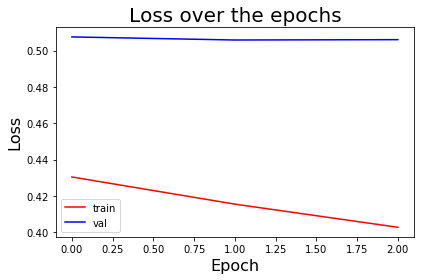

In [21]:
plot_loss(model_history)

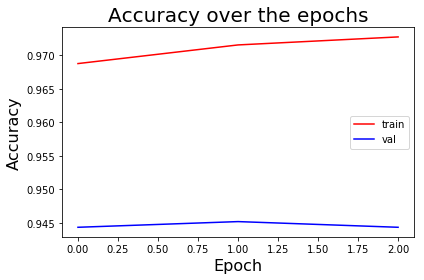

In [22]:
plot_accuracy(model_history)

We can load a saved model as below:

In [23]:
from keras.models import load_model
filepath = 'IMDb_model.epoch02-loss0.26.hdf5'
saved_model = load_model(filepath)

To view the Tensorboard plots, you need to follow the steps:
* Navigate to the directory where your notebook is stored
* Run `tensorboard --logdir="./logs"` in the command prompt of your Terminal/Command Window
* Extract the http address from the output of the above command
* Open the http address in your web browser

Let us use the network to predict the sentiment for a movie review.

In [24]:
review1 = ["""It plays on our knowledge and our senses, and the sets are well done."""]
input_review1 = vectorizer.transform(review1).toarray()
saved_model.predict(input_review1)

array([[0.6896285]], dtype=float32)

The network has predicted the review to be positive with approx. $69$% probability. However, if we add a word "terribly" as shown below, which actually adds to the positive sentiment of the review, the network gets the prediction wrong. 

In [25]:
review1 = ["""It plays on our knowledge and our senses, and the sets are terribly well done."""]
input_review1 = vectorizer.transform(review1).toarray()
saved_model.predict(input_review1)

array([[0.27836576]], dtype=float32)

It is now predicting the review to be negative with approx. $72$% probability. You can try using $n$-grams for the vectorizer and see if it helps.